###Dataset: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
This dataset contains 10,1000 images with 101 classes, each class having 750 Train images and 250 Test images.

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 16, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mahireddy1318/udemy_pytorch_tutorials.git
    !mv udemy_pytorch_tutorials/going_modular .
    #!mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf udemy_pytorch_tutorials
    from going_modular import data_setup, engine
    from going_modular.helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'udemy_pytorch_tutorials'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 334 (delta 4), reused 324 (delta 1), pack-reused 0
Receiving objects: 100% (334/334), 34.00 MiB | 42.36 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from torchvision import models

EffNetB1_weights = models.EfficientNet_B1_Weights.DEFAULT
#print(EffNetB1_weights)
EffNetB1 = models.efficientnet_b1(weights= EffNetB1_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 111MB/s] 


In [ ]:
import torch
from torch import nn
from torchvision import models

def create_effnetb1_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model

    EffNetB1_weights = models.EfficientNet_B1_Weights.DEFAULT
    #print(EffNetB1_weights)
    transforms = EffNetB1_weights.transforms()
    model = models.efficientnet_b1(weights= EffNetB1_weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes),
    )

    return model, transforms

In [ ]:
effnetb1, effnetb1_transforms = create_effnetb1_model(num_classes=101, seed=42)


In [ ]:
from torchinfo import summary
summary(model=effnetb1,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
effnetb1_transforms

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
food101_effnetb1_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb1_transforms
])
food101_effnetb1_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [ ]:
#Getting dataset Food vision from Pytorch datasets
from pathlib import Path
data_dir = Path('data/')
data_dir.mkdir(parents=True, exist_ok=True)
train_dataset = torchvision.datasets.Food101(root=data_dir, split='train',
                                             transform=food101_effnetb1_transforms,
                                             download=True)
test_dataset = torchvision.datasets.Food101(root=data_dir, split='test',
                                            transform=effnetb1_transforms,
                                            download=True)

100%|██████████| 4996278331/4996278331 [03:37<00:00, 23021622.94it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
class_names = train_dataset.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
len(train_dataset)*0.2, len(test_dataset)*0.2

(15150.0, 5050.0)

In [ ]:
from torch.utils.data import random_split

In [ ]:
def split_dataset(dataset:torchvision.datasets,
                  split_size: float=0.2,
                  seed:int = 42):
  length1 = int(len(dataset) * split_size)
  length2 = (len(dataset) - length1)
  split_1, split_2 = torch.utils.data.random_split(dataset=dataset, lengths=[length1, length2], generator=torch.manual_seed(seed))
  print(f'INFO Splitting dataset of lenght {len(dataset)} into split of size: {length1} and {length2}')
  return split_1, split_2

In [ ]:
train_food101_20_percent, _ = split_dataset(train_dataset, split_size=0.2)

test_food101_20_percent, _ = split_dataset(test_dataset, split_size=0.2)

print(f'train_food101_20_percent:{train_food101_20_percent}, test_food101_20_percent{test_food101_20_percent}')

INFO Splitting dataset of lenght 75750 into split of size: 15150 and 60600
INFO Splitting dataset of lenght 25250 into split of size: 5050 and 20200
train_food101_20_percent:<torch.utils.data.dataset.Subset object at 0x7ecabaded4b0>, test_food101_20_percent<torch.utils.data.dataset.Subset object at 0x7ecabaded5d0>


In [ ]:
!pwd

/content


In [ ]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

train_dataloader_food101_20_percent, test_dataloader_food101_20_percent

(<torch.utils.data.dataloader.DataLoader at 0x7ecabaded150>,
 <torch.utils.data.dataloader.DataLoader at 0x7ecabaded600>)

torch.Size([3, 240, 240])
torch.Size([240, 240, 3])


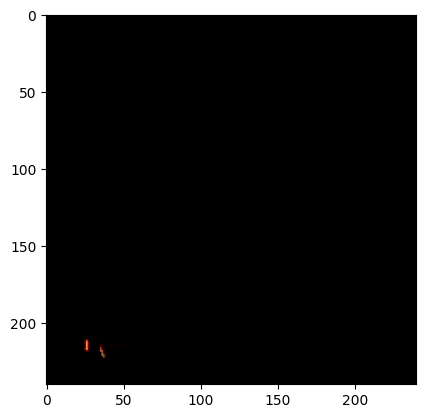

In [ ]:
import matplotlib.pyplot
image, label = next(iter(train_dataloader_food101_20_percent))
print(image[0].shape)
image = image[0].permute(1,2,0)
print(image.shape)
plt.imshow(image)

In [ ]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb1.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb1_food101_results = engine.train(model=effnetb1,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=10,
                                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.8785 | train_acc: 0.2889 | test_loss: 3.1724 | test_acc: 0.4532
Epoch: 2 | train_loss: 3.0402 | train_acc: 0.4443 | test_loss: 2.6579 | test_acc: 0.5428
Epoch: 3 | train_loss: 2.7021 | train_acc: 0.5052 | test_loss: 2.4160 | test_acc: 0.5735
Epoch: 4 | train_loss: 2.5386 | train_acc: 0.5329 | test_loss: 2.2742 | test_acc: 0.5993
Epoch: 5 | train_loss: 2.4458 | train_acc: 0.5513 | test_loss: 2.1991 | test_acc: 0.6125
Epoch: 6 | train_loss: 2.3605 | train_acc: 0.5690 | test_loss: 2.1651 | test_acc: 0.6244
Epoch: 7 | train_loss: 2.3155 | train_acc: 0.5816 | test_loss: 2.1181 | test_acc: 0.6319
Epoch: 8 | train_loss: 2.2686 | train_acc: 0.5937 | test_loss: 2.1030 | test_acc: 0.6350
Epoch: 9 | train_loss: 2.2343 | train_acc: 0.6022 | test_loss: 2.0680 | test_acc: 0.6365
Epoch: 10 | train_loss: 2.2028 | train_acc: 0.6098 | test_loss: 2.0698 | test_acc: 0.6400


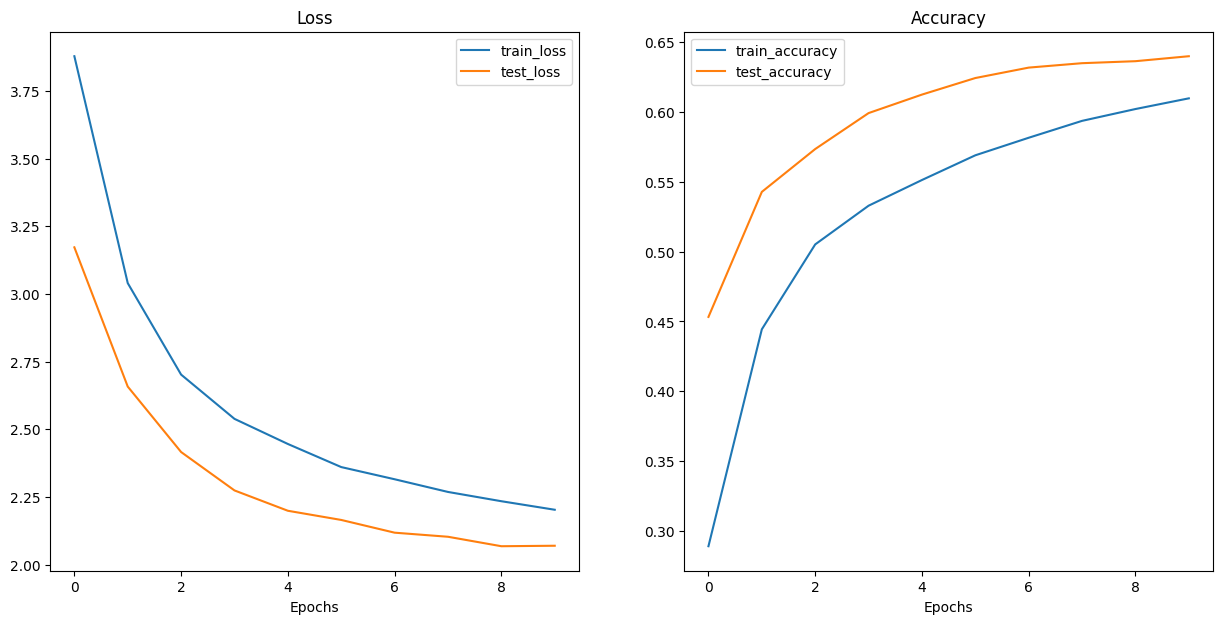

In [ ]:
from going_modular.helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb1_food101_results)

In [ ]:
from going_modular import utils

# Create a model path
#os.makedirs('models/', exist_ok=True)
effnetb2_food101_model_path = "pretrained_effnetb1_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb1,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/pretrained_effnetb1_feature_extractor_food101_20_percent.pth


In [ ]:
#!rm -rf models

In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb1_food101, effnetb1_transforms = create_effnetb1_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb1_food101.load_state_dict(torch.load("models/pretrained_effnetb1_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb1_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB1 feature extractor Food101 model size: {pretrained_effnetb1_food101_model_size} MB")

Pretrained EffNetB1 feature extractor Food101 model size: 25 MB


In [ ]:
from pathlib import Path
foodvision101_demo = Path('demo/foodvision_big')
foodvision101_demo.mkdir(parents=True, exist_ok=True)

foodvision101_demo_examples = foodvision101_demo / 'examples'
foodvision101_demo_examples.mkdir(parents=True, exist_ok=True)

In [ ]:
!ls demo/foodvision_big/

examples


In [ ]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg
!mv /content/04-pizza-dad.jpeg /content/demo/foodvision_big/examples

--2024-01-23 15:11:29--  https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6612 (6.5K) [text/plain]
Saving to: ‘04-pizza-dad.jpeg.1’

04-pizza-dad.jpeg.1 100%[===================>]   6.46K  --.-KB/s    in 0s      

2024-01-23 15:11:29 (89.2 MB/s) - ‘04-pizza-dad.jpeg.1’ saved [6612/6612]



In [ ]:
!mv /content/models/pretrained_effnetb1_feature_extractor_food101_20_percent.pth /content/demo/foodvision_big

In [ ]:
type(class_names)

list

In [ ]:
class_names_path = '/content/demo/foodvision_big/class_names.txt'
with open(class_names_path, 'w') as f:
    for line in class_names:
        f.write(f"{line}\n")

In [ ]:
with open(class_names_path, 'r') as f:
  classes_loaded = [label.strip() for label in f.readlines()]

classes_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
%%writefile demo/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb1_model(num_classes:int=101,
                          seed:int=42):
    """Creates an EfficientNetB1 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 101.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB1 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB1 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b1(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes),
    )

    return model, transforms

Writing demo/foodvision_big/model.py


In [ ]:
%%writefile demo/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb1_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb1, effnetb1_transforms = create_effnetb1_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb1.load_state_dict(
    torch.load(
        f="pretrained_effnetb1_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb1_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb1.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb1(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔 Classification Model"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demo/foodvision_big/app.py


In [ ]:
%%writefile demo/foodvision_big/requirements.txt
torch==2.1.0
torchvision==0.16.2
gradio==3.45.0

Writing demo/foodvision_big/requirements.txt


In [ ]:
!ls demo/foodvision_big

app.py		 examples  pretrained_effnetb1_feature_extractor_food101_20_percent.pth
class_names.txt  model.py  requirements.txt


In [ ]:
!cd demo/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpeg (deflated 67%)
  adding: model.py (deflated 55%)
  adding: pretrained_effnetb1_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


In [ ]:
try:
  from google.colab import files
  files.download('demo/foodvision_big.zip')
except:
  print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>